In [61]:
from ocetrac.model import Tracker

import pytest
import xarray as xr
import numpy as np
import scipy.ndimage
from skimage.measure import regionprops
from skimage.measure import label as label_np
import dask.array as dsa
from xarray.tests import raise_if_dask_computes
%matplotlib inline

def example_data():

    x = np.arange(-10,11,1)
    y = np.arange(-10,11,1)
    xdim = 'x'; ydim = 'y'
    da = xr.DataArray(np.zeros((5,21,21)),
                     dims=["time", ydim, xdim],
                     coords={"time": np.arange(1,6), ydim: y, xdim: x},
                    )
    da[0, 2:6, 2:9] = 1
    da[0, 12:18, -6:-2] = 1

    for i in enumerate(da.time[:-1].values):
        da[i[1],:,:] = da.isel(time=i[0]).roll(x=2, roll_coords=False)

    mask = xr.DataArray(np.ones(da.isel(time=0).shape),
                    dims=[ydim, xdim],
                    coords={ydim: y, xdim: x}
                   )
    mask[11:14,:3] = 0
    mask[:4,5:6] = 0

    return da, mask

@pytest.mark.parametrize("radius", [2, 4])
@pytest.mark.parametrize("min_size_quartile", [0.75, 0.80])
@pytest.mark.parametrize('xdim', ['lon', 'longitude', 'whoo'])
@pytest.mark.parametrize('ydim', ['lat', 'latitude', 'whaa'])
@pytest.mark.parametrize('dask', [True, False])
def test_track(da, mask, radius, min_size_quartile, xdim, ydim, dask):

    da = da.rename({'x':xdim, 'y':ydim})
    mask = mask.rename({'x':xdim, 'y':ydim})
    if dask:
        da = da.chunk({'time':1})

    tracker = Tracker(da, mask, radius, min_size_quartile, xdim=xdim, ydim=ydim)
    new_labels = tracker.track()

    assert (
        new_labels.attrs["percent area reject"]
        + new_labels.attrs["percent area accept"]
    ) == 1.0

def test_track_dask_lazy(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y'):
    # Check that dask computation is lazy and results are the same for eager/lazy compute

    da_chunked = da.chunk({'time':1})
    # mask_chunked = mask.chunk({xdim:-1, ydim:-1})
    mask_chunked = mask # dont chunk for now to not trigger the error in `self.mask == 0).all():`

    tracker = Tracker(da, mask, radius, min_size_quartile, xdim=xdim, ydim=ydim)
    labels = tracker.track()

    with raise_if_dask_computes(): #temporarily deactivated
        tracker_dask = Tracker(da_chunked, mask_chunked, radius, min_size_quartile, xdim=xdim, ydim=ydim)
        labels_dask = tracker_dask.track()

    xr.testing.assert_allclose(labels, labels_dask)

def test_morphological_operations(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y'):

    tracker = Tracker(da.chunk({'time': 1}), mask, radius, min_size_quartile, xdim, ydim)
    binary_images = tracker._morphological_operations()

    assert isinstance(binary_images.data, dsa.Array)

    ocetrac_guess = da.where(binary_images==True, drop=False, other=np.nan)
    best_guess = da.where(da>0, drop=False, other=np.nan)
    part = ocetrac_guess.isin(best_guess)
    whole = best_guess.isin(best_guess)

    assert part.sum().values/whole.sum().values*100 >= 80
    assert part.sum().values == 260

def test_apply_mask(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y'):
    
    tracker = Tracker(da.chunk({'time': 1}), mask, radius, min_size_quartile, xdim, ydim)
    binary_images = tracker._morphological_operations()
    binary_images_with_mask = tracker._apply_mask(binary_images, mask)
    assert (binary_images_with_mask.where(mask==0).sum()==0).all()

def test_filter_area(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y'):
    
    tracker = Tracker(da.chunk({'time': 1}), mask, radius, min_size_quartile, xdim, ydim)
    binary_images = tracker._morphological_operations()
    binary_images_with_mask = tracker._apply_mask(binary_images, mask)
    area, min_area, binary_labels, N_initial = tracker._filter_area(binary_images_with_mask)

    assert N_initial.astype(int) == 2
    assert min_area == 129
    

def test_label_either(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y'):
    
    tracker = Tracker(da.chunk({'time': 1}), mask, radius, min_size_quartile, xdim, ydim)
    binary_images = tracker._morphological_operations()
    binary_images_with_mask = tracker._apply_mask(binary_images, mask)
    labels, num = tracker._label_either(binary_images_with_mask, return_num= True, connectivity=3)

    assert labels[2,:,:].max() == 3.
    assert all([i in labels[2,:,:] for i in range(0,4)])

def test_wrap(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y'):
    
    tracker = Tracker(da.chunk({'time': 1}), mask, radius, min_size_quartile, xdim, ydim)
    binary_images = tracker._morphological_operations()
    binary_images_with_mask = tracker._apply_mask(binary_images, mask)
    area, min_area, binary_labels, N_initial = tracker._filter_area(binary_images_with_mask)
    labels, num = tracker._label_either(binary_images_with_mask, return_num= True, connectivity=3)
    labels_wrapped, N_final = tracker._wrap(labels)

    assert N_final == 2


In [13]:
da, mask = example_data()

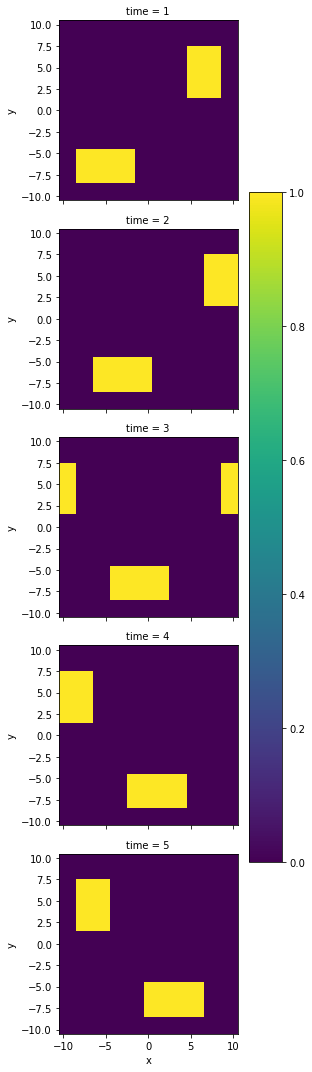

In [14]:
da.plot(x="x", y="y", col="time", col_wrap=1)

In [21]:
radius = 2
min_size_quartile = .75
xdim = 'x'
ydim = 'y'
dask=False

In [22]:
test_track(da, mask, radius, min_size_quartile, xdim, ydim, dask)

minimum area:  129.0
inital objects identified 	 2
final objects tracked 	 1


In [23]:
test_track_dask_lazy(da, mask, radius=2, min_size_quartile=0, xdim='x', ydim='y')

minimum area:  108.0
inital objects identified 	 2
final objects tracked 	 2


RuntimeError: Too many computes. Total: 1 > max: 0.

In [25]:
test_morphological_operations(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y')

In [43]:
test_apply_mask(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y')

In [51]:
test_filter_area(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y')

minimum area:  129.0


In [62]:
test_label_either(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y')

In [63]:
test_wrap(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y')

minimum area:  129.0
